# How a  non-linear inversion should work

In [1]:
%matplotlib inline
from __future__ import print_function, division
from future.builtins import super, range
import cPickle as pickle
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_validation import KFold, train_test_split
from fatiando import utils, mesher
from fatiando.vis import mpl
from fatiando.gravmag import talwani
from inversion import NonLinearModel, LevMarq, ACOR, SteepestDescent, ScipyOptimizer, \
                       Smoothness1D, TotalVariation1D, Damping

In [2]:
class BasinPolyGrav(NonLinearModel):
    def __init__(self, xlim, npoints, props, top=0, eps=1, z0=None, 
                 damping=None, smoothness=None, sharpness=None, beta=None):
        if z0 is None:
            z0 = 3e3*np.ones(npoints)
        super().__init__(optimizer=LevMarq(initial=z0))
        self.xlim = xlim
        self.npoints = npoints
        self.props = props
        self.top = top
        self.eps = eps
        regul = []
        if damping is not None:
            regul.append([damping, Damping(npoints)])
        if smoothness is not None:
            regul.append([smoothness, Smoothness1D(npoints)])
        if sharpness is not None:
            args = dict()
            if beta is not None:
                args['beta'] = beta
            regul.append([sharpness, TotalVariation1D(npoints, **args)])
        self.config(regularization=regul)
    
    @property
    def vertices_(self):
        h = self.top
        x1, x2 = self.xlim
        nverts = self.npoints + 2
        verts = np.empty((nverts, 2))
        verts[:, 0] = np.linspace(x1, x2, nverts)[::-1]
        verts[:, 1] = np.concatenate([[h], self.p_, [h]])
        return verts
    
    @property
    def polygon_(self):
        return mesher.Polygon(self.vertices_, props=self.props)
        
    def predict(self, x, z):
        return talwani.gz(x, z, [self.polygon_])
    
    def jacobian(self, x, z):
        verts = self.vertices_
        delta = np.array([0, self.eps])
        A = np.empty((x.size, self.npoints))
        for i in range(self.npoints):
            diff_verts = [verts[i + 2], verts[i + 1] - delta,
                          verts[i], verts[i + 1] + delta]
            diff = mesher.Polygon(diff_verts, self.props)
            A[:, i] = talwani.gz(x, z, [diff])/(2*delta[1])
        return A
    
    def fit(self, x, z, gz, **kwargs):
        super().fit(args=(x, z), data=gz, **kwargs)
        return self

In [3]:
# Make some synthetic data to test the inversion
# The model will be a polygon.
# Reverse x because vertices must be clockwise.
xs = np.linspace(0, 100000, 200)[::-1]
depths = (-1e-15*(xs - 50000)**4 + 8000 -
          3000*np.exp(-(xs - 70000)**2/(10000**2)))
depths -= depths.min()  # Reduce depths to zero
depths[(xs > 30e3) & (xs < 40e3)] -= 2000
props = {'density': -300}
model = mesher.Polygon(np.transpose([xs, depths]), props)
x = np.linspace(0, 100000, 100)
z = -100*np.ones_like(x)
data = talwani.gz(x, z, [model])

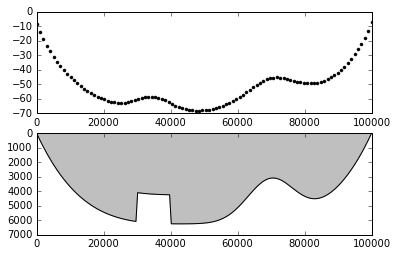

In [4]:
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(x, data, '.k')
ax = plt.subplot(2, 1, 2)
mpl.polygon(model, fill='gray', alpha=0.5)
ax.invert_yaxis()

In [5]:
xlim = [x.min(), x.max()]
inv = BasinPolyGrav(xlim, npoints=100, props=model.props, top=0).fit(x, z, data)

inversion/gradient_descent.py:123: RuntimeWarning: Exited because maximum iterations reached. Might not have achieved convergence. Try increasing the maximum number of iterations allowed.
  RuntimeWarning)


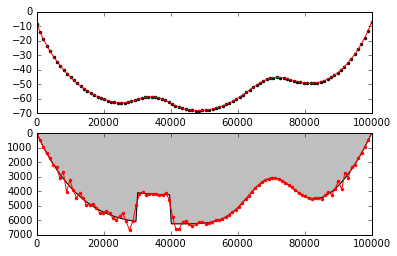

In [6]:
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(x, data, '.k')
plt.plot(x, inv.predict(x, z), '-r')
ax = plt.subplot(2, 1, 2)
mpl.polygon(model, fill='gray', alpha=0.5)
mpl.polygon(inv.polygon_, style='.-r')
ax.invert_yaxis()

In [8]:
pickle.loads(pickle.dumps(inv))

CPU times: user 21.9 s, sys: 28 ms, total: 21.9 s
Wall time: 21.9 s


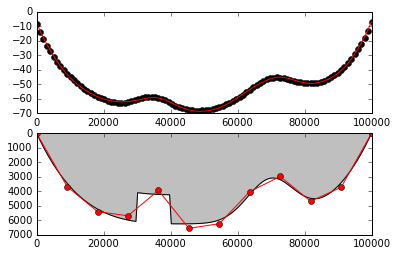

In [8]:
%%time
inv = BasinPolyGrav(xlim, npoints=10, props=model.props)
acor = ACOR(bounds=[1000, 7000], nparams=inv.npoints, seed=0)
inv.config(optimizer=acor).fit(x, z, data)

plt.figure()
plt.subplot(2, 1, 1)
plt.plot(x, data, 'ok')
plt.plot(x, inv.predict(x, z), '-r')
ax = plt.subplot(2, 1, 2)
mpl.polygon(model, fill='gray', alpha=0.5)
mpl.polygon(inv.polygon_, style='o-r')
ax.invert_yaxis()

/home/leo/bin/anaconda/envs/inv-again/lib/python2.7/site-packages/scipy/optimize/_minimize.py:381: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  RuntimeWarning)
/home/leo/bin/anaconda/envs/inv-again/lib/python2.7/site-packages/scipy/optimize/_minimize.py:385: RuntimeWarning: Method Nelder-Mead does not use Hessian information (hess).
  RuntimeWarning)


CPU times: user 3.08 s, sys: 0 ns, total: 3.08 s
Wall time: 3.08 s


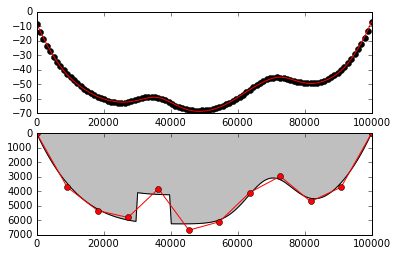

In [9]:
%%time
inv = BasinPolyGrav(xlim, npoints=10, props=model.props)
opt = ScipyOptimizer(method='Nelder-Mead', x0=3e3*np.ones(inv.npoints))
inv.config(optimizer=opt).fit(x, z, data)

plt.figure()
plt.subplot(2, 1, 1)
plt.plot(x, data, 'ok')
plt.plot(x, inv.predict(x, z), '-r')
ax = plt.subplot(2, 1, 2)
mpl.polygon(model, fill='gray', alpha=0.5)
mpl.polygon(inv.polygon_, style='o-r')
ax.invert_yaxis()

# Profiling

In [10]:
%prun -T prof.txt -s tottime -q BasinPolyGrav(xlim, npoints=300, props=model.props, top=0).fit(x, z, data)
!head -n 30 prof.txt

 
*** Profile printout saved to text file u'prof.txt'. 
         188745 function calls in 7.803 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     9031    7.212    0.001    7.327    0.001 talwani.py:29(gz)
       30    0.191    0.006    6.126    0.204 <ipython-input-3-f7ebd60562a9>:36(jacobian)
    11403    0.055    0.000    0.055    0.000 {numpy.core.multiarray.array}
       30    0.045    0.001    0.046    0.002 linalg.py:296(solve)
     9181    0.027    0.000    0.027    0.000 {numpy.core.multiarray.zeros}
     9031    0.025    0.000    0.106    0.000 mesher.py:105(__init__)
     9031    0.023    0.000    0.073    0.000 numeric.py:86(zeros_like)
       91    0.023    0.000    0.023    0.000 {numpy.core.multiarray.dot}
     9031    0.017    0.000    0.017    0.000 mesher.py:48(__init__)
     9031    0.014    0.000    0.014    0.000 {numpy.core.multiarray.empty_like}
     9031    0.014    0.000    0.016    0.000 mesher.p

# Regularization

In [6]:
class BasinPolyGravCV(BasinPolyGrav):
    def __init__(self, xlim, npoints, props, top=0, eps=1, z0=None, jobs=1,
                 damping=None, smoothness=None, sharpness=None, beta=None):
        super().__init__(xlim, npoints, props, top=top, eps=eps, z0=z0)
        self.jobs = jobs
        if damping is not None:
            self.regul = Damping(npoints)
            self.mus = damping
        elif smoothness is not None:
            self.regul = Smoothness1D(npoints)
            self.mus = smoothness
        elif sharpness is not None:
            self.regul = TotalVariation1D(npoints, beta)
            self.mus = sharpness            
        
    def fit(self, x, z, gz, cv=None, **kwargs):
        if cv is None:
            cv = KFold(gz.size, n_folds=3, shuffle=True)
        pool = multiprocessing.Pool(processes=self.jobs)
        tmp = []
        for mu in self.mus:
            regul = [[mu, self.regul]]
            res = pool.apply_async(fit_score, args=(self, x, z, gz, regul, cv, kwargs))
            tmp.append(res)
        self.scores_ = np.array([res.get() for res in tmp])
        pool.close()
        score_means = self.scores_[:, 0]
        self.best_ = np.nanargmax(score_means)
        self.regul_param_ = self.mus[self.best_]        
        self.config(regularization=[[self.regul_param_, self.regul]])
        super().fit(x, z, gz, **kwargs)        
        return self
    
    def _fit_score(self, x, z, data, train, test, **kwargs):
        super().fit(x[train], z[train], data[train], **kwargs)
        score = self.score(x[test], z[test], data[test])
        return score        

def fit_score(cls, x, z, data, regul, cv, kwargs):
    scores = []
    for train, test in cv:
        cls.config(regularization=regul)        
        scores.append(cls._fit_score(x, z, data, train, test, **kwargs))
    return scores

In [7]:
def plot_scores(inv):
    score_means = inv.scores_.mean(axis=1)
    score_stds = inv.scores_.std(axis=1)
    plt.plot(mus, score_means, '.-k')
    plt.plot(mus[inv.best_], score_means[inv.best_], '^y', markersize=10)
    plt.plot(mus, np.array(score_means) + np.array(score_stds), '--b')
    plt.plot(mus, np.array(score_means) - np.array(score_stds), '--b')
    plt.xscale('log')

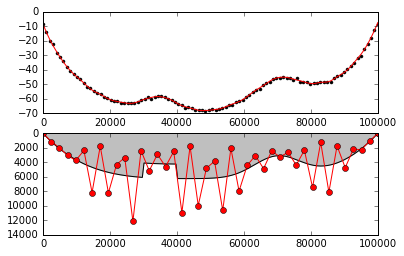

In [8]:
noisy = utils.contaminate(data, 0.5, seed=2)

npoints = 40
inv = BasinPolyGrav(xlim, npoints=npoints, props=model.props).fit(x, z, noisy)
z0 = inv.p_

plt.figure()
plt.subplot(2, 1, 1)
plt.plot(x, noisy, '.k')
plt.plot(x, inv.predict(x, z), '-r')
ax = plt.subplot(2, 1, 2)
mpl.polygon(model, fill='gray', alpha=0.5)
mpl.polygon(inv.polygon_, style='o-r')
ax.invert_yaxis()

In [9]:
%%time
mus = np.logspace(-10, 0, 20)
cv = KFold(noisy.size, n_folds=3, shuffle=True, random_state=42)

smooth = BasinPolyGravCV(xlim=xlim, npoints=npoints, props=model.props, z0=z0,
                         smoothness=mus, jobs=4)
smooth.fit(x, z, noisy, cv=cv)

print('Best mu:', smooth.regul_param_)

Best mu: 1.62377673919e-06
CPU times: user 928 ms, sys: 16 ms, total: 944 ms
Wall time: 20.1 s


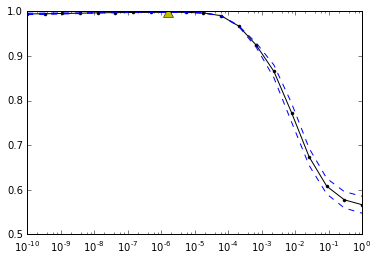

In [10]:
plot_scores(smooth)

In [ ]:
%%time
sharp = BasinPolyGravCV(xlim=xlim, npoints=npoints, props=model.props, z0=smooth.p_,
                         sharpness=mus, beta=1e-5, jobs=4)
sharp.config(optimizer=ScipyOptimizer('Nelder-Mead', x0=smooth.p_))
sharp.fit(x, z, noisy, cv=cv)
print('Best mu:', sharp.regul_param_)

/home/leo/bin/anaconda/envs/inv-again/lib/python2.7/site-packages/scipy/optimize/_minimize.py:381: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  RuntimeWarning)
/home/leo/bin/anaconda/envs/inv-again/lib/python2.7/site-packages/scipy/optimize/_minimize.py:381: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  RuntimeWarning)
/home/leo/bin/anaconda/envs/inv-again/lib/python2.7/site-packages/scipy/optimize/_minimize.py:381: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  RuntimeWarning)
/home/leo/bin/anaconda/envs/inv-again/lib/python2.7/site-packages/scipy/optimize/_minimize.py:385: RuntimeWarning: Method Nelder-Mead does not use Hessian information (hess).
  RuntimeWarning)
/home/leo/bin/anaconda/envs/inv-again/lib/python2.7/site-packages/scipy/optimize/_minimize.py:385: RuntimeWarning: Method Nelder-Mead does not use Hessian information (hess).
  RuntimeWarning)
/home/leo/bin/anaconda/envs/inv-aga

In [ ]:
plot_scores(sharp)

In [ ]:
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(x, noisy, '.k')
plt.plot(x, smooth.predict(x, z), '-r')
plt.plot(x, sharp.predict(x, z), '-b')
ax = plt.subplot(2, 1, 2)
mpl.polygon(model, fill='gray', alpha=0.5)
mpl.polygon(smooth.polygon_, style='.-r')
mpl.polygon(sharp.polygon_, style='.-b')
ax.invert_yaxis()